In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from prophet import Prophet
import warnings
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex

c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
# Suppress logging messages
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

In [4]:
df = pd.read_csv('all_upwork_jobs.csv')
df

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India
...,...,...,...,...,...,...,...,...
244823,Need Facebook advertising experts to launch pr...,https://www.upwork.com/jobs/Need-Facebook-adve...,2024-03-24 13:28:38+00:00,True,20.0,100.0,NaN,Zambia
244824,Digital/Telemarketing/Sales/OutSide Sales,https://www.upwork.com/jobs/Digital-Telemarket...,2024-03-24 13:40:52+00:00,False,NaN,NaN,100.0,Sri Lanka
244825,WordPress Template Edits,https://www.upwork.com/jobs/WordPress-Template...,2024-03-24 13:37:50+00:00,True,5.0,30.0,NaN,United States
244826,ELEMENTOR PRO For quick fix (Wordpress),https://www.upwork.com/jobs/ELEMENTOR-PRO-For-...,2024-03-24 13:52:15+00:00,False,NaN,NaN,15.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


In [6]:
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

### Task 1: Analyze the correlation between job title keywords and offered salaries

In [7]:
# Convert columns to numeric and handle errors
df['hourly_low'] = pd.to_numeric(df['hourly_low'], errors='coerce')
df['hourly_high'] = pd.to_numeric(df['hourly_high'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

In [8]:
# Fill NaN values in 'budget' with the average of 'hourly_low' and 'hourly_high'
df['budget'] = df.apply(
    lambda row: row['budget'] if pd.notna(row['budget']) else (row['hourly_low'] + row['hourly_high']) / 2,
    axis=1
)

In [9]:
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget             42162
country             5077
dtype: int64

In [10]:
# The 'salary' column can now be directly assigned from 'budget'
df['salary'] = df['budget']

# Drop rows with missing salary
df.dropna(subset=['salary'], inplace=True)

In [11]:
df.isnull().sum()

title                  0
link                   0
published_date         0
is_hourly              0
hourly_low        103891
hourly_high       103891
budget                 0
country             4152
salary                 0
dtype: int64

In [12]:
# Convert 'title' to lowercase
df['title'] = df['title'].str.lower()

In [13]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

In [15]:
# Fit and transform the 'title' column
title_matrix = vectorizer.fit_transform(df['title'])

In [16]:
# Convert salary to a dense array
salary = df['salary'].values

In [17]:
# Compute correlations using sparse matrix operations
# Calculate the mean of the salary
mean_salary = salary.mean()
# Calculate the deviations from the mean
deviation_salary = salary - mean_salary
# Convert deviations to a sparse matrix
deviation_salary_sparse = csr_matrix(deviation_salary).T

In [18]:
# Calculate the correlation coefficient for each keyword
correlations = (title_matrix.T @ deviation_salary_sparse).toarray().flatten() / (title_matrix.shape[0] - 1)

In [19]:
# Create a DataFrame for correlations
correlation_df = pd.DataFrame({
    'keyword': vectorizer.get_feature_names_out(),
    'correlation': correlations
})

In [20]:
# Sort the correlations and get the top 20
top_keywords = correlation_df.sort_values(by='correlation', ascending=False).head(20)

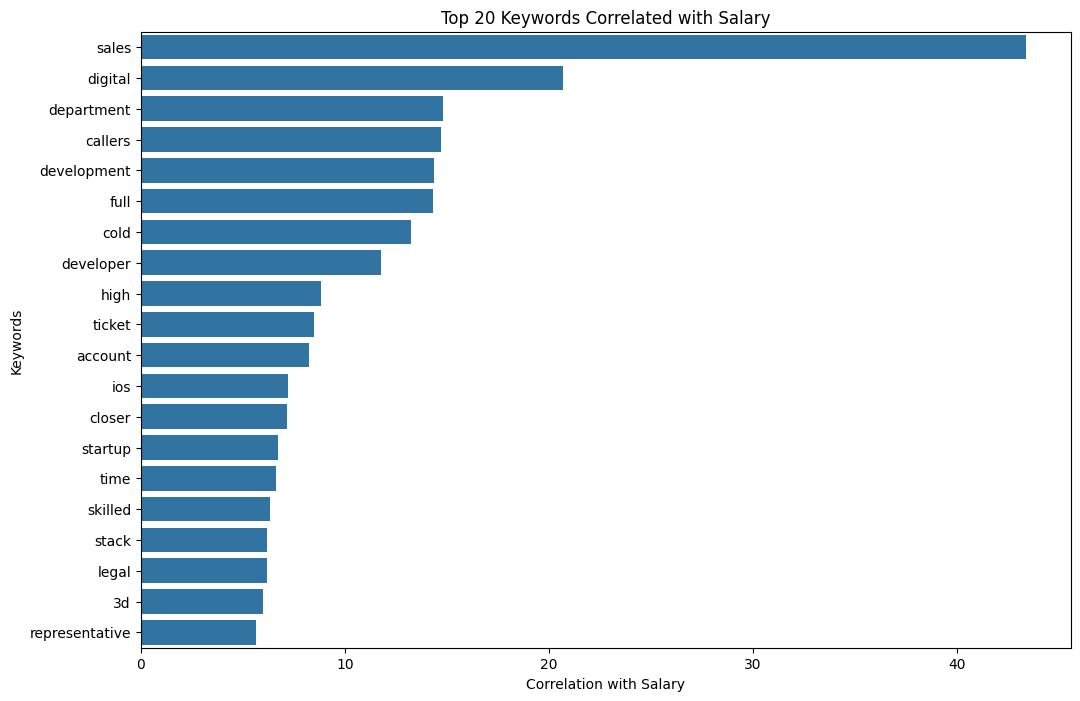

In [21]:
# Plot the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords['correlation'], y=top_keywords['keyword'])
plt.title('Top 20 Keywords Correlated with Salary')
plt.xlabel('Correlation with Salary')
plt.ylabel('Keywords')
plt.show()

### Task 2: Identify emerging job categories based on posting frequency

In [22]:
# Convert 'published_date' column to datetime
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

In [23]:
# Drop rows with missing 'published_date' or 'title'
df.dropna(subset=['published_date', 'title'], inplace=True)

In [24]:
# Extract year and month from the 'published_date'
df['year_month'] = df['published_date'].dt.to_period('M')

In [25]:
# Group by 'title' and 'year_month' to get the count of job postings for each title per month
job_trends = df.groupby(['title', 'year_month']).size().reset_index(name='count')

In [26]:
# Pivot the table to have 'year_month' as index, 'title' as columns, and 'count' as values
job_trends_pivot = job_trends.pivot(index='year_month', columns='title', values='count').fillna(0)

In [27]:
# Calculate the rolling average to smooth the trend (optional)
job_trends_pivot_smooth = job_trends_pivot.rolling(window=3, min_periods=1).mean()

In [28]:
# Calculate the trend for each job title (e.g., slope of the trend line)
trend_data = job_trends_pivot_smooth.reset_index().melt(id_vars='year_month', var_name='title', value_name='count')
trend_summary = trend_data.groupby('title')['count'].apply(lambda x: x.diff().mean()).reset_index(name='trend')

In [29]:
# Get the top emerging job titles by sorting by the trend value
top_emerging_jobs = trend_summary.sort_values(by='trend', ascending=False).head(20)

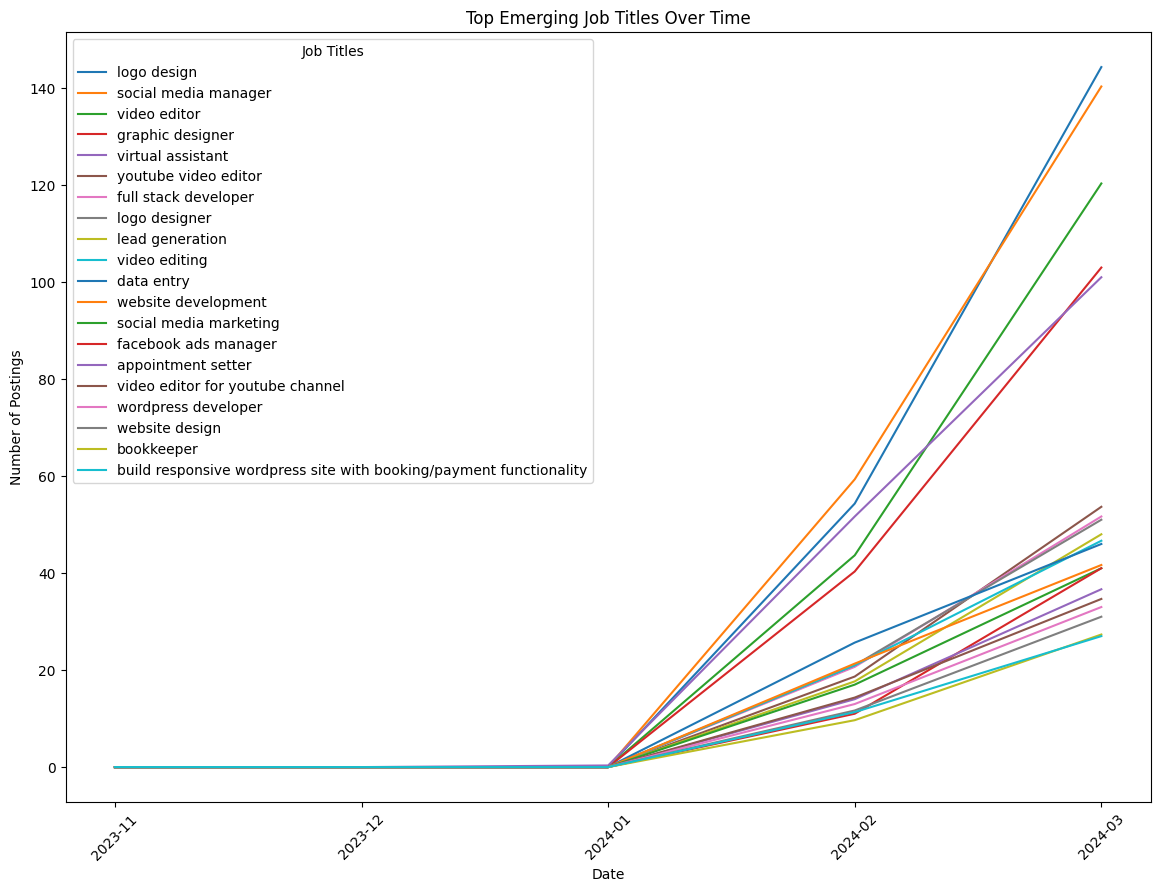

In [30]:
# Plot the trends for the top emerging job titles
plt.figure(figsize=(14, 10))
for job in top_emerging_jobs['title']:
    plt.plot(job_trends_pivot_smooth.index.astype(str), job_trends_pivot_smooth[job], label=job)

plt.title('Top Emerging Job Titles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Postings')
plt.legend(title='Job Titles')
plt.xticks(rotation=45)
plt.show()

### Task 3: Predict high-demand job roles by analyzing job posting patterns over time

In [31]:
# Convert 'year_month' to datetime for Prophet
job_trends['year_month'] = job_trends['year_month'].dt.to_timestamp()

In [32]:
# Function to forecast job postings for a given job title
def forecast_job_postings(title, periods=12):
    # Filter data for the specific job title
    df_title = job_trends[job_trends['title'] == title][['year_month', 'count']]
    df_title.columns = ['ds', 'y']
    
    # Ensure there are at least 2 non-NaN rows
    if df_title.dropna().shape[0] < 2:
        return None
    
    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(df_title)
    
    # Create a dataframe for future dates
    future = model.make_future_dataframe(periods=periods, freq='M')
    
    # Forecast future job postings
    forecast = model.predict(future)
    
    return forecast

In [33]:
# List of unique job titles
job_titles = job_trends['title'].unique()

In [34]:
# Forecast for each job title and store the results
forecast_results = {}
titles_with_insufficient_data = []

for title in job_titles:
    forecast = forecast_job_postings(title)
    if forecast is not None:
        forecast_results[title] = forecast
    else:
        titles_with_insufficient_data.append(title)

01:36:27 - cmdstanpy - INFO - Chain [1] start processing
01:36:29 - cmdstanpy - INFO - Chain [1] done processing
01:36:39 - cmdstanpy - INFO - Chain [1] start processing
01:36:40 - cmdstanpy - INFO - Chain [1] done processing
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
01:36:42 - cmdstanpy - INFO - Chain [1] done processing
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing
01:36:49 - cmdstanpy - INFO - Chain [1] start processing
01:36:52 - cmdstanpy - INFO - Chain [1] done processing
01:36:58 - cmdstanpy - INFO - Chain [1] start processing
01:36:58 - cmdstanpy - INFO - Chain [1] done processing
01:36:59 - cmdstanpy - INFO - Chain [1] start processing
01:37:00 - cmdstanpy - INFO - Chain [1] done processing
01:37:09 - cmdstanpy - INFO - Chain [1] start processing
01:37:10 - cmdstanpy - INFO - Chain [1] done processing
01:37:14 - cmdstanpy - INFO - Chain [1] start processing
01:37:16 - cmdstanpy - INFO - Chain [1]

In [35]:
# Print summary of titles with insufficient data
print(f"Job titles with insufficient data for forecasting: {len(titles_with_insufficient_data)}")
print(", ".join(titles_with_insufficient_data[:10]) + ("..." if len(titles_with_insufficient_data) > 10 else ""))

Job titles with insufficient data for forecasting: 162288
! top tier accounts! onlyfans sellers wanted !, !! need immediate help on a small adobe illustrator graphics job, !!! amazon aws / devops/ nginx / performance / security / dns guru needed!!!, !!! wordpress elementor designer needed !!!, ### long-term office assistant/communciator/juggler needed - 20 hours per week ###, #1142 writer with experience in statistics, #1143 10 minute impulse speech, #4 long-term - scriptwriter needed for celebrity news niche youtube videos, #7668: german into canadian english translation, #7669: chinese simplified into us english translation...


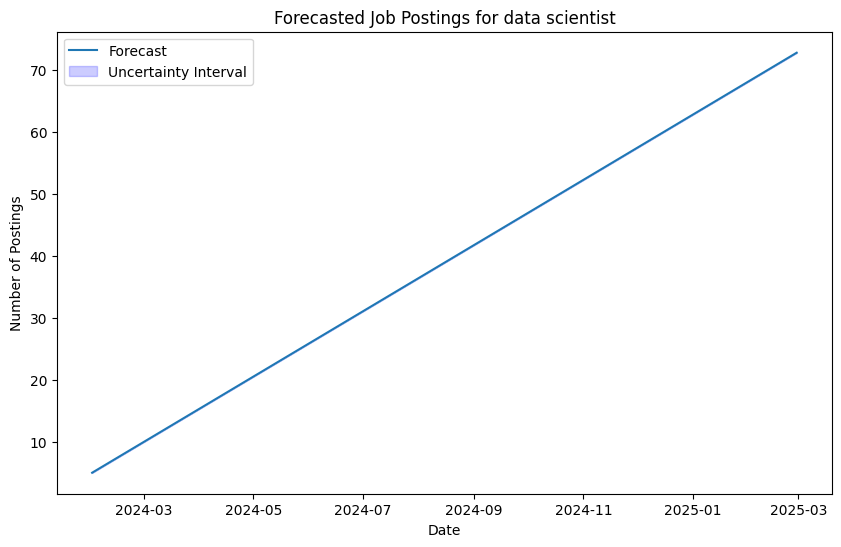

In [36]:
# Plot the forecast for a specific job title (example: 'data scientist')
title_to_plot = 'data scientist'
if title_to_plot in forecast_results:
    forecast_to_plot = forecast_results[title_to_plot]

    plt.figure(figsize=(10, 6))
    plt.plot(forecast_to_plot['ds'], forecast_to_plot['yhat'], label='Forecast')
    plt.fill_between(forecast_to_plot['ds'], forecast_to_plot['yhat_lower'], forecast_to_plot['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')
    plt.title(f'Forecasted Job Postings for {title_to_plot}')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.legend()
    plt.show()
else:
    print(f"No forecast available for {title_to_plot}")

### Task 4: Compare average hourly rates across different countries

In [37]:
# Calculate the average hourly rate
df['average_hourly_rate'] = df[['hourly_low', 'hourly_high']].mean(axis=1)

In [38]:
# Drop rows where 'location' or 'average_hourly_rate' is NaN
df.dropna(subset=['country', 'average_hourly_rate'], inplace=True)

In [39]:
# Group by country and calculate the average hourly rate
average_hourly_rates = df.groupby('country')['average_hourly_rate'].mean().reset_index()

In [40]:
# Sort the data by average hourly rate for better visualization
average_hourly_rates.sort_values(by='average_hourly_rate', ascending=False, inplace=True)

In [41]:
# Select the top 20 countries
top_20_countries = average_hourly_rates.head(20)

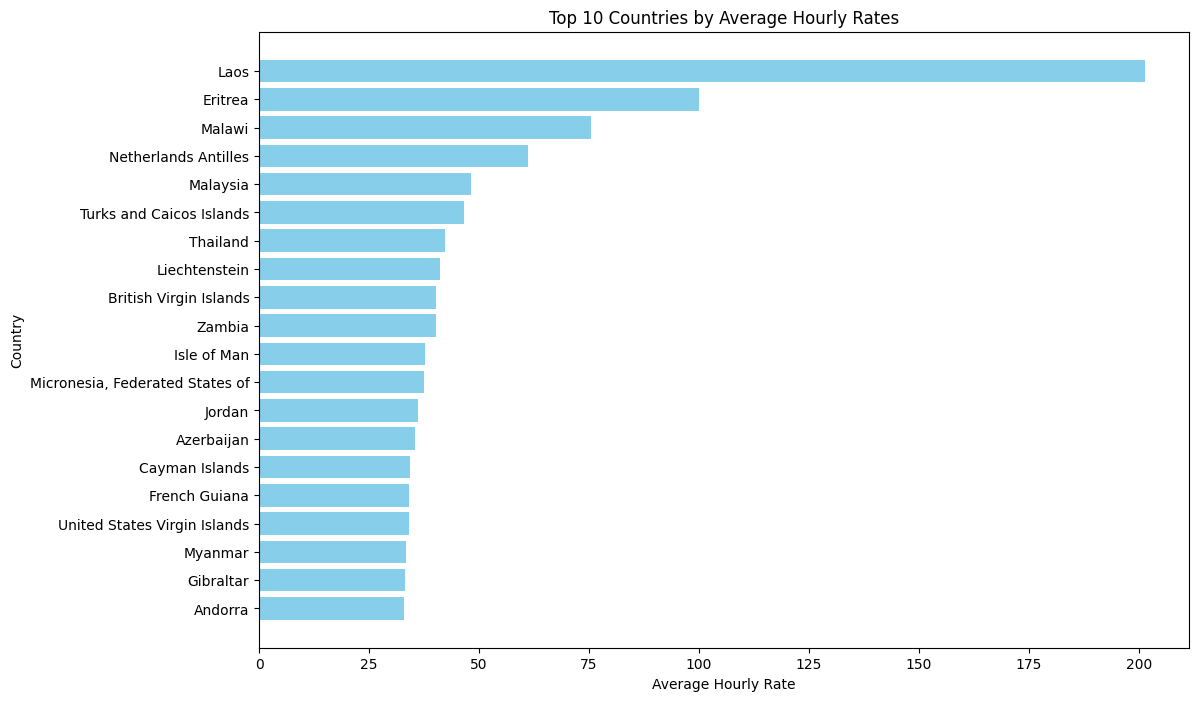

In [42]:
# Plot the average hourly rates for the top 10 countries
plt.figure(figsize=(12, 8))
plt.barh(top_20_countries['country'], top_20_countries['average_hourly_rate'], color='skyblue')
plt.xlabel('Average Hourly Rate')
plt.ylabel('Country')
plt.title('Top 10 Countries by Average Hourly Rates')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest rates at the top
plt.show()

### Task 5: Create a job recommendation engine based on current job postings

In [43]:
# Use only the title column for the combined features
df['combined_features'] = df['title']

In [44]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Apply TF-IDF to the title column
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [45]:
# Build the Annoy index
num_features = tfidf_matrix.shape[1]
annoy_index = AnnoyIndex(num_features, 'angular')

# Add items to the Annoy index
for i in range(tfidf_matrix.shape[0]):
    annoy_index.add_item(i, tfidf_matrix[i].toarray()[0])

# Build the index
annoy_index.build(10)  # You can change the number of trees for trade-off between speed and accuracy

True

In [46]:
# Function to get recommendations
def get_recommendations(job_title, n_recommendations=10):
    try:
        idx = df[df['title'] == job_title].index[0]
    except IndexError:
        return "Job title not found in dataset."

    # Get the Annoy index of the job
    job_vector = tfidf_matrix[idx].toarray()[0]

    # Get the nearest neighbors
    nearest_neighbors = annoy_index.get_nns_by_vector(job_vector, n_recommendations + 1)  # +1 because the job itself will be the nearest

    # Exclude the job itself from the recommendations
    nearest_neighbors = [n for n in nearest_neighbors if n != idx]

    # Return the top N most similar jobs
    return df[['title', 'budget', 'hourly_low', 'hourly_high']].iloc[nearest_neighbors]

# Example: Get recommendations for a job title
print(get_recommendations('sales'))

                                                    title  budget  hourly_low  \
230347                      marketing strategy consultant    35.5        12.0   
128600          marketing and content strategy consultant    50.0        40.0   
199253                             marketing and branding    25.0         5.0   
85841                                  marketing strategy    11.5         3.0   
163962                                 marketing strategy    21.0        12.0   
237185                                 marketing strategy   102.5        80.0   
196470  email marketing campaign specialist for brandi...    65.0        30.0   
79099                                marketing consultant     5.5         5.0   
167628                               marketing consultant    30.0        25.0   
90282                   marketing strategy/brand strategy    93.5        70.0   

        hourly_high  
230347         59.0  
128600         60.0  
199253         45.0  
85841          20.0 

### Task 6: Track changes in job market dynamics over months

In [47]:
# Count the number of job postings per month
monthly_job_postings = df['year_month'].value_counts().sort_index()

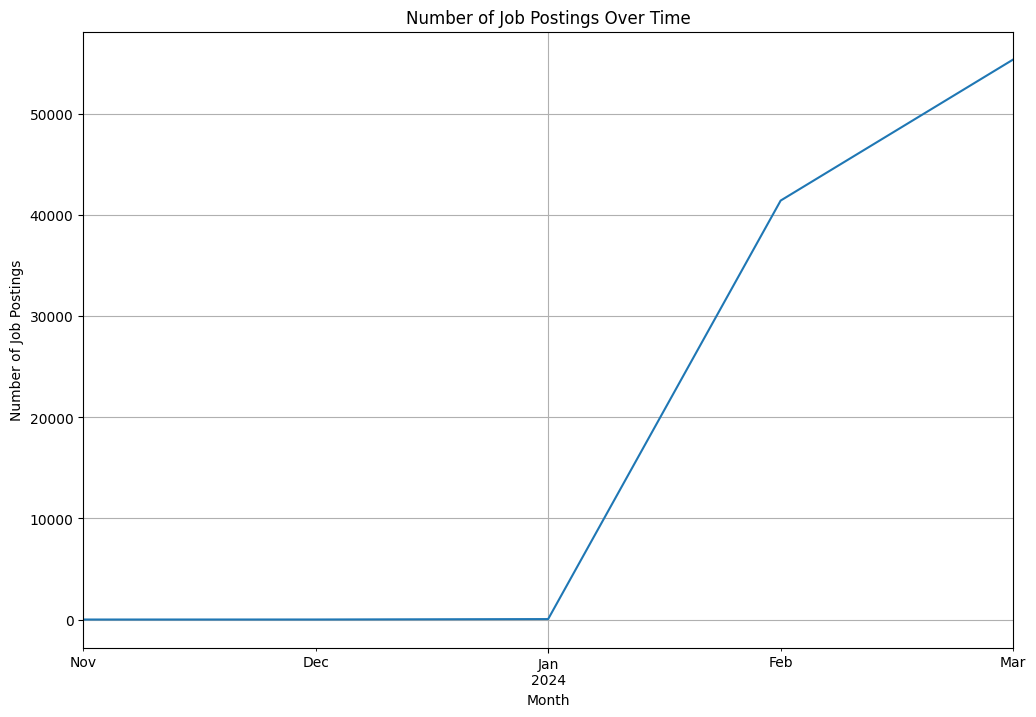

In [48]:
# Plot the number of job postings over time
plt.figure(figsize=(12, 8))
monthly_job_postings.plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Number of Job Postings Over Time')
plt.grid(True)
plt.show()

In [49]:
# Calculate the average budget per month
df['average_salary'] = df[['hourly_low', 'hourly_high']].mean(axis=1)
df['average_salary'] = df['average_salary'].fillna(df['budget'])

monthly_avg_salary = df.groupby('year_month')['average_salary'].mean()

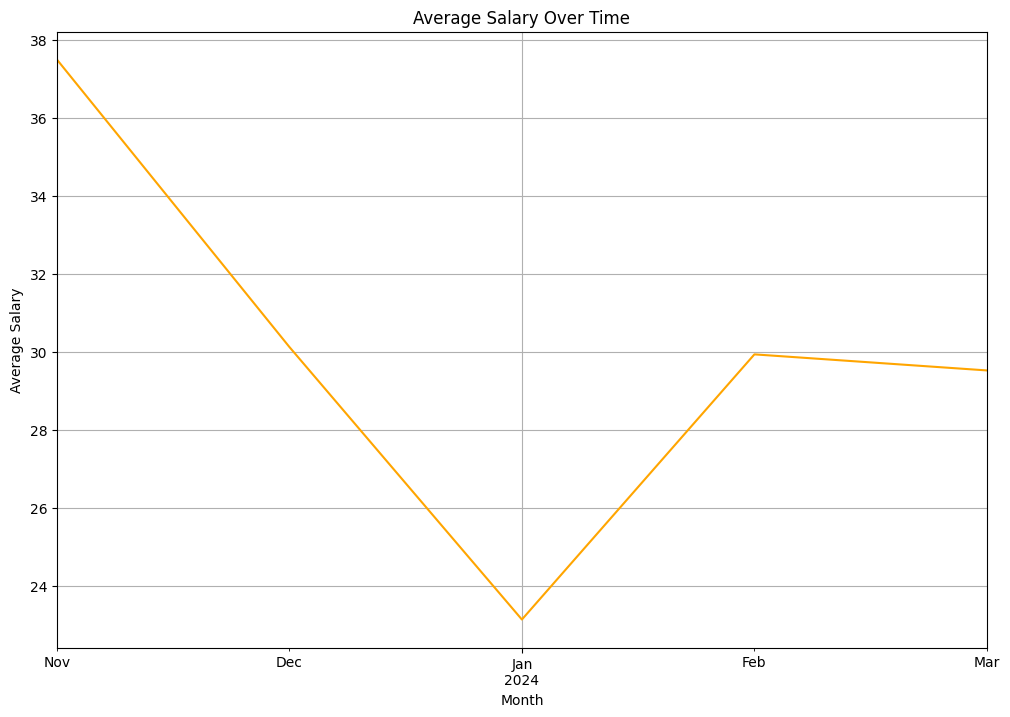

In [50]:
# Plot the average salary over time
plt.figure(figsize=(12, 8))
monthly_avg_salary.plot(kind='line', color='orange')
plt.xlabel('Month')
plt.ylabel('Average Salary')
plt.title('Average Salary Over Time')
plt.grid(True)
plt.show()

In [51]:
# Count the number of job postings for specific job titles per month
job_title_trends = df.groupby(['year_month', 'title']).size().unstack(fill_value=0)

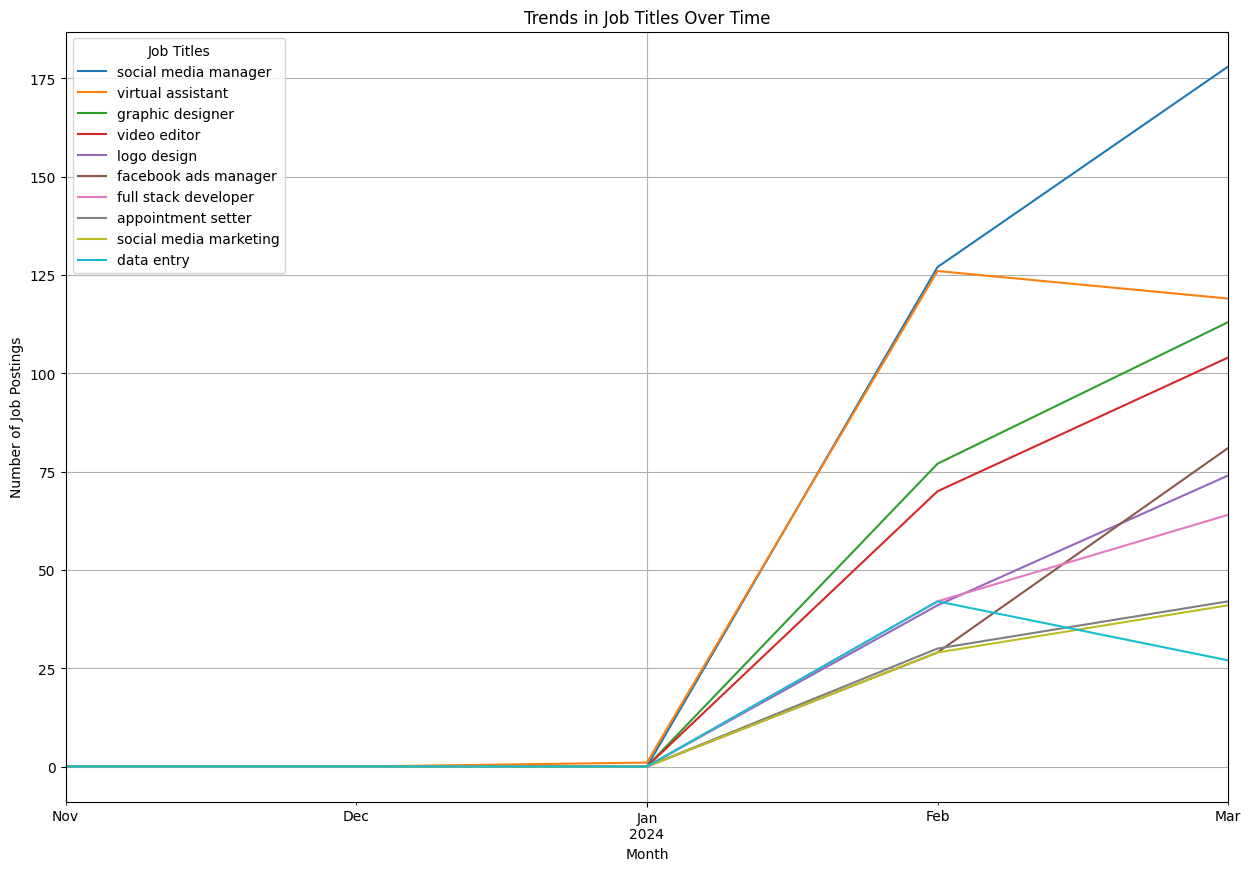

In [52]:
# Plot trends for top job titles
top_job_titles = job_title_trends.sum().sort_values(ascending=False).head(10).index
job_title_trends[top_job_titles].plot(figsize=(15, 10))
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Trends in Job Titles Over Time')
plt.legend(title='Job Titles')
plt.grid(True)
plt.show()

### Task 7: Investigate trends in the remote work landscape

In [53]:
# Remote column doesn't exist, we might need to use text search on the job title or description
df['is_remote'] = df['title'].str.contains('remote', case=False, na=False)

In [54]:
# Count the number of remote job postings per month
monthly_remote_job_postings = df[df['is_remote']].groupby('year_month').size()

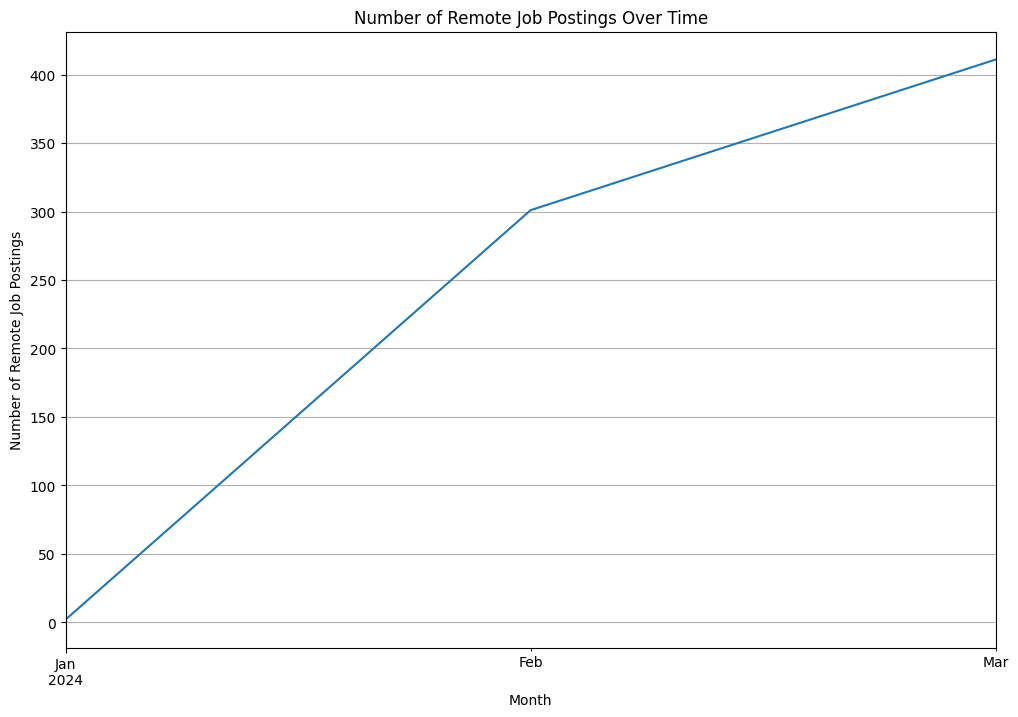

In [55]:
# Plot the number of remote job postings over time
plt.figure(figsize=(12, 8))
monthly_remote_job_postings.plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Number of Remote Job Postings')
plt.title('Number of Remote Job Postings Over Time')
plt.grid(True)
plt.show()

In [56]:
# Count the number of on-site job postings per month
monthly_onsite_job_postings = df[~df['is_remote']].groupby('year_month').size()

In [57]:
# Ensure the index is in datetime format
monthly_remote_job_postings.index = monthly_remote_job_postings.index.to_timestamp()
monthly_onsite_job_postings.index = monthly_onsite_job_postings.index.to_timestamp()

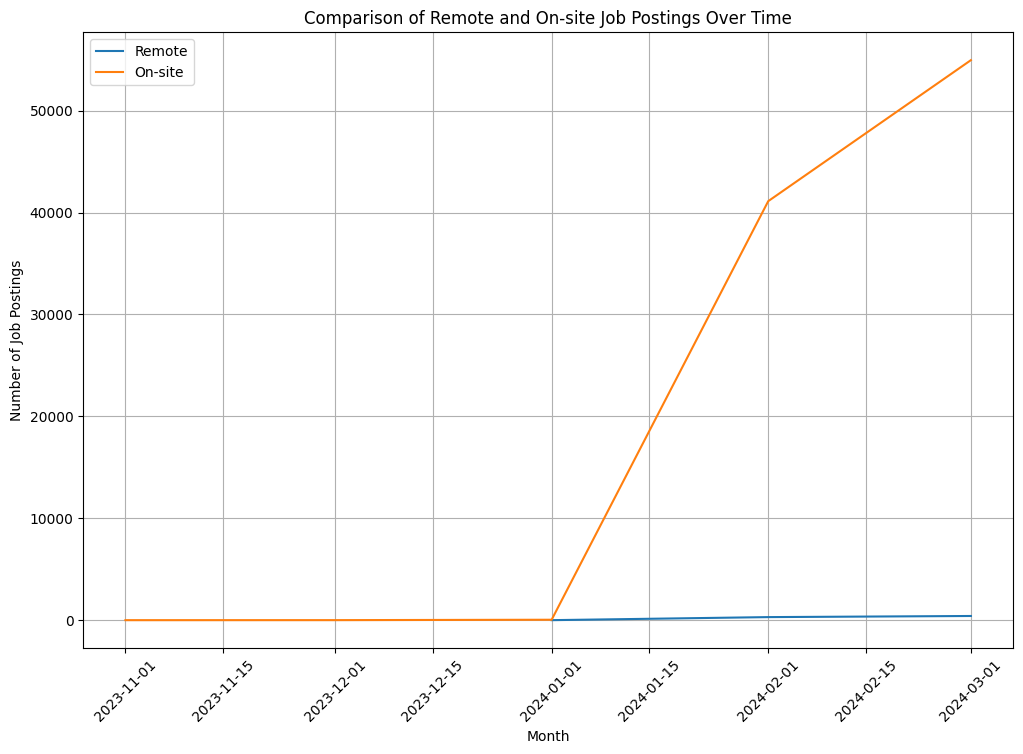

In [58]:
# Plot the comparison
plt.figure(figsize=(12, 8))
plt.plot(monthly_remote_job_postings.index, monthly_remote_job_postings, label='Remote')
plt.plot(monthly_onsite_job_postings.index, monthly_onsite_job_postings, label='On-site')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.title('Comparison of Remote and On-site Job Postings Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [59]:
# Assuming there's a 'country' column in the dataset
remote_job_countries = df[df['is_remote']].groupby('country').size()

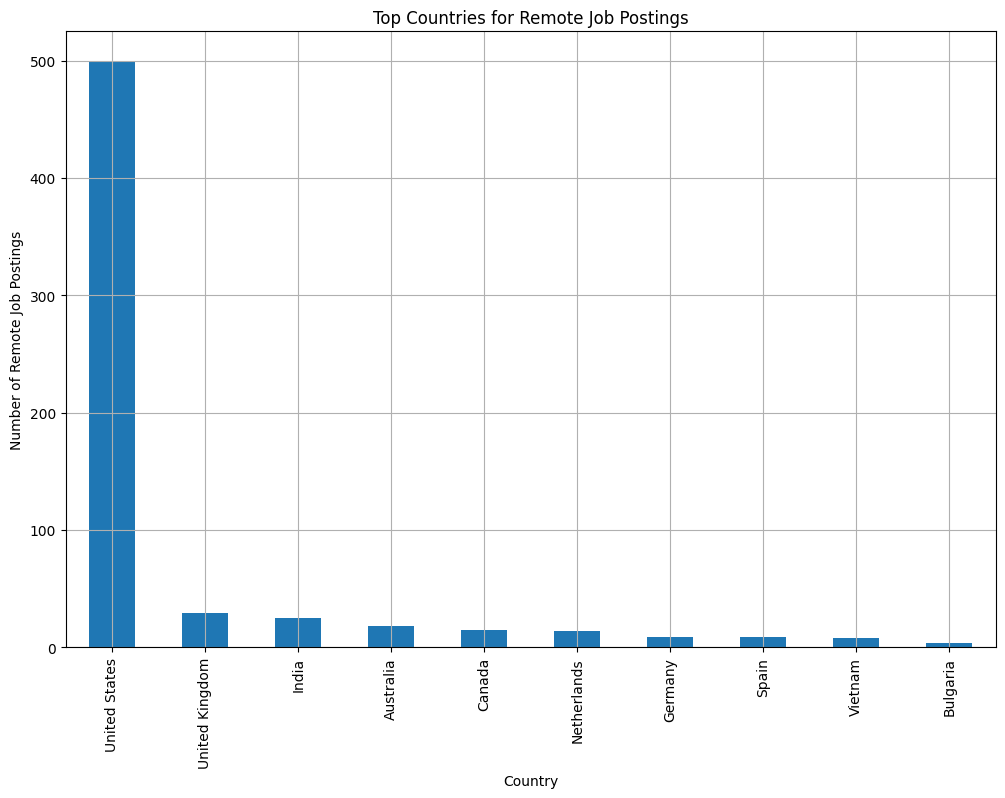

In [60]:
# Plot the distribution of remote job postings by country
plt.figure(figsize=(12, 8))
remote_job_countries.sort_values(ascending=False).head(10).plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Remote Job Postings')
plt.title('Top Countries for Remote Job Postings')
plt.grid(True)
plt.show()

### Task 8: Predict future job market trends

In [61]:
# Convert 'published_date' to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

In [62]:
# Extract month and count job postings per month
df['month'] = df['published_date'].dt.to_period('M')

In [63]:
# Group by month to get the count of job postings per month
monthly_job_postings = df.groupby('month').size().reset_index(name='job_postings')

In [64]:
# Convert period to timestamp for Prophet
monthly_job_postings['month'] = monthly_job_postings['month'].dt.to_timestamp()

In [65]:
# Rename columns to match Prophet's expected input
monthly_job_postings.rename(columns={'month': 'ds', 'job_postings': 'y'}, inplace=True)

In [66]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the monthly job postings data
model.fit(monthly_job_postings)

04:04:42 - cmdstanpy - INFO - Chain [1] start processing
04:04:42 - cmdstanpy - INFO - Chain [1] done processing


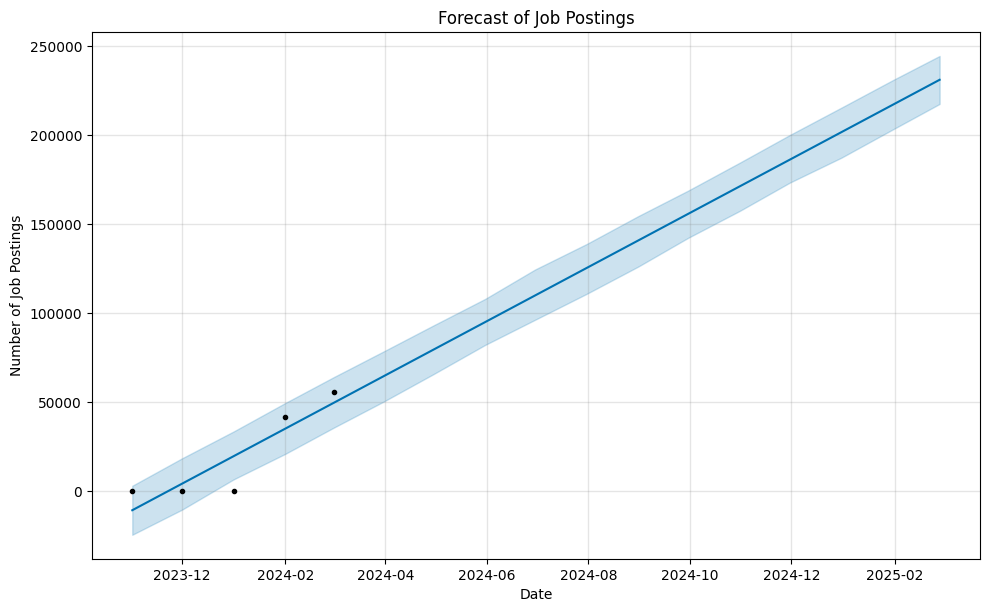

In [67]:
# Create a dataframe with future dates for prediction
future = model.make_future_dataframe(periods=12, freq='M')  # Predicting 12 months into the future

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Job Postings')
plt.xlabel('Date')
plt.ylabel('Number of Job Postings')
plt.show()